In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns



import data

In [25]:
base_path = "../cleaned_data/"

# Load base demographic table (one row per ID)
df = pd.read_csv(base_path + "SA_var_cleaned.csv", low_memory=False)

# Load brand_health
brand_health = pd.read_csv(base_path + "Brand_Health_cleaned.csv", low_memory=False)
brand_health.columns = brand_health.columns.str.strip().str.lower()

# Convert numeric columns and select proper aggregation
numeric_cols = [
    "p3m", "p1m", "comprehension", "brand_likability", "nps_p3m",
    "fre_visit", "ppa", "spending", "spending_use"
]
for col in numeric_cols:
    brand_health[col] = pd.to_numeric(brand_health[col], errors="coerce")

# Use "first" for nps_p3m_group
agg_health = brand_health.groupby("id").agg({
    "p3m": "max",
    "p1m": "max",
    "comprehension": "mean",
    "brand_likability": "mean",
    "nps_p3m": "mean",
    "nps_p3m_group": "first",
    "fre_visit": "sum",
    "ppa": "mean",
    "spending": "sum",
    "spending_use": "sum"
}).reset_index().rename(columns={"id": "ID"})
df = df.merge(agg_health, on="ID", how="left")

# Load segmentation
segmentation = pd.read_csv(base_path + "Segmentation_cleaned.csv", low_memory=False)
segmentation.columns = segmentation.columns.str.strip().str.lower()
agg_seg = segmentation.groupby("id").agg({
    "segmentation": "first",
    "visit": "sum",
    "spending": "sum",
    "ppa": "mean"
}).reset_index().rename(columns={"id": "ID"})
df = df.merge(agg_seg, on="ID", how="left")

# Load and merge other tables (brand_image, companion, dayofweek, daypart, needstate)
# 1. Brand_Image
brand_image = pd.read_csv(base_path + "Brand_Image_cleaned.csv", low_memory=False)
brand_image.columns = brand_image.columns.str.strip().str.lower()
df = df.merge(brand_image.groupby("id")["awareness"].first().reset_index().rename(columns={"id": "ID"}), on="ID", how="left")

# 2. Companion
companion = pd.read_csv(base_path + "Companion_cleaned.csv", low_memory=False)
companion.columns = companion.columns.str.strip().str.lower()
df = df.merge(companion.groupby("id")["companion#group"].first().reset_index().rename(columns={"id": "ID"}), on="ID", how="left")

# 3. Dayofweek
dayofweek = pd.read_csv(base_path + "Dayofweek_cleaned.csv", low_memory=False)
dayofweek.columns = dayofweek.columns.str.strip().str.lower()
df = df.merge(
    dayofweek.groupby("id").agg({"visit#dayofweek": "sum", "weekday#end": "first"}).reset_index().rename(columns={"id": "ID"}),
    on="ID", how="left"
)

# 4. Daypart
daypart = pd.read_csv(base_path + "Daypart_cleaned.csv", low_memory=False)
daypart.columns = daypart.columns.str.strip().str.lower()
df = df.merge(
    daypart.groupby("id").agg({"visit#daypart": "sum", "daypart": "first"}).reset_index().rename(columns={"id": "ID"}),
    on="ID", how="left"
)

# 5. Needstate
needstate = pd.read_csv(base_path + "NeedstateDayDaypart_cleaned.csv", low_memory=False)
needstate.columns = needstate.columns.str.strip().str.lower()
df = df.merge(
    needstate.groupby("id").agg({"needstategroup": "first", "needstates": "first"}).reset_index().rename(columns={"id": "ID"}),
    on="ID", how="left"
)

print("Merge completed. Final shape:", df.shape)
df.head()


Merge completed. Final shape: (11761, 37)


,ID,City,Group_size,Age,MPI#Mean,TOM,BUMO,BUMO_Previous,MostFavourite,Gender,...,spending_y,ppa_y,awareness,companion#group,visit#dayofweek,weekday#end,visit#daypart,daypart,needstategroup,needstates
0,348226,0.0,3.0,29.0,5499.0,16.0,16.0,13.0,16.0,0.0,...,NaN,NaN,trung nguyên,Friends,20.0,Weekends,12.0,9 AM - before 11 AM,Drinking beverages,Drinking coffee
1,358485,1.0,3.0,25.0,5499.0,16.0,16.0,13.0,16.0,1.0,...,NaN,NaN,highlands coffee,Friends,16.0,Weekdays,14.0,5 PM - before 9 PM,Drinking beverages,Drinking coffee
2,360729,0.0,3.0,25.0,5499.0,16.0,16.0,13.0,16.0,0.0,...,NaN,NaN,trung nguyên,Friends,20.0,Weekends,12.0,5 PM - before 9 PM,Drinking beverages,Drinking coffee
3,360737,0.0,3.0,24.0,5499.0,16.0,16.0,13.0,16.0,1.0,...,NaN,NaN,trung nguyên,Friends,28.0,Weekdays,24.0,Before 9 AM,Drinking beverages,Drinking coffee
4,361753,0.0,3.0,26.0,5499.0,16.0,16.0,13.0,16.0,1.0,...,NaN,NaN,street,Friends,20.0,Weekends,17.0,5 PM - before 9 PM,Drinking beverages,Drinking coffee


Các cột trong df sau khi merge

In [26]:
for col in df.columns:
    print(col)

ID
City
Group_size
Age
MPI#Mean
TOM
BUMO
BUMO_Previous
MostFavourite
Gender
Age#Group#2
MPI#2
Occupation
Occupation#group
Year
p3m
p1m
comprehension
brand_likability
nps_p3m
nps_p3m_group
fre_visit
ppa_x
spending_x
spending_use
segmentation
visit
spending_y
ppa_y
awareness
companion#group
visit#dayofweek
weekday#end
visit#daypart
daypart
needstategroup
needstates


# STEP 1: DATA PREPROCESSING & FEATURE ENGINEERING

## Nhóm feature cần chuẩn bị 

In [49]:
features = [
    "comprehension", "brand_likability", "nps_p3m", "nps_p3m_group",   # perceptual
    "visit", "ppa_y", "spending_y", "visit#dayofweek", "visit#daypart", # behavioral
    "segmentation",                                                    # segmentation
    "companion#group",                                                 # companionship
    "needstategroup", "needstates",                                    # need state
    "Age", "Gender", "Occupation", "MPI#2"                             # demographics
]

## Xử lý missing và encode 

In [80]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Tạo X để model sau dùng
X = df[features].copy()

# Xử lý missing value
X = X.fillna(X.median(numeric_only=True))

# Điền 0 cho các cột perceptual bị thiếu
X["comprehension"] = X["comprehension"].fillna(0)
X["brand_likability"] = X["brand_likability"].fillna(0)

# Với các cột còn lại thì giữ như cũ
X = X.fillna(X.median(numeric_only=True))

# Encode các cột dạng object (text)
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Kiểm tra X
print("Xử lý xong feature. Kích thước:", X.shape)
X.head(10)


Xử lý xong feature. Kích thước: (11761, 18)


,comprehension,brand_likability,nps_p3m,nps_p3m_group,visit,ppa_y,spending_y,visit#dayofweek,visit#daypart,segmentation,companion#group,needstategroup,needstates,Age,Gender,Occupation,MPI#2,segment_cluster
0,0.0,0.0,7.500000,0,8.0,25.0,160.0,20.0,12.0,5,4,0,0,29.0,0.0,27.0,1,1
1,0.0,0.0,8.250000,2,8.0,25.0,160.0,16.0,14.0,5,4,0,0,25.0,1.0,27.0,1,1
2,0.0,0.0,8.000000,3,8.0,25.0,160.0,20.0,12.0,5,4,0,0,25.0,0.0,27.0,1,1
3,0.0,0.0,7.333333,0,8.0,25.0,160.0,28.0,24.0,5,4,0,0,24.0,1.0,24.0,1,1
4,0.0,0.0,8.000000,2,8.0,25.0,160.0,20.0,17.0,5,4,0,0,26.0,1.0,23.0,1,1
5,0.0,0.0,8.333333,2,8.0,25.0,160.0,28.0,24.0,5,4,0,0,33.0,1.0,27.0,1,1
6,0.0,0.0,8.500000,3,8.0,25.0,160.0,28.0,24.0,5,4,0,0,33.0,1.0,23.0,1,1
7,0.0,0.0,7.000000,3,8.0,25.0,160.0,30.0,25.0,5,4,0,0,34.0,1.0,24.0,1,1
8,0.0,0.0,8.000000,2,8.0,25.0,160.0,4.0,4.0,5,4,0,2,28.0,0.0,27.0,1,1
9,0.0,0.0,7.333333,0,8.0,25.0,160.0,4.0,3.0,5,4,0,0,29.0,1.0,27.0,1,1


### Do NaN ở cột Comprehension với Brand_likebility thường ở khách ko biết hoặc ko nhớ brand.Coi như ko hiểu, ko thích ->0 điểm

## Kiểm tra sau khi xử lý missing value và encode

In [55]:
print(X.dtypes)
print(X.isnull().sum().sum())  # Số NaN sau xử lý

comprehension       float64
brand_likability    float64
nps_p3m             float64
nps_p3m_group         int64
visit               float64
ppa_y               float64
spending_y          float64
visit#dayofweek     float64
visit#daypart       float64
segmentation          int64
companion#group       int64
needstategroup        int64
needstates            int64
Age                 float64
Gender              float64
Occupation          float64
MPI#2                 int64
dtype: object
0


# STEP 2: Customer Segmentation Modeling

## 🎯 Tiêu chí chọn: Những đặc trưng không phụ thuộc vào churn . Thể hiện hành vi, cảm nhận, nhân khẩu học

In [56]:
cluster_features = [
    "comprehension", "brand_likability", "nps_p3m",
    "visit", "ppa_y", "spending_y",
    "segmentation", "needstategroup", "Age", "MPI#2"
]

X_cluster = X[cluster_features].copy()


## Standardize

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


## Chọn số lượng cụm (K) – Elbow method

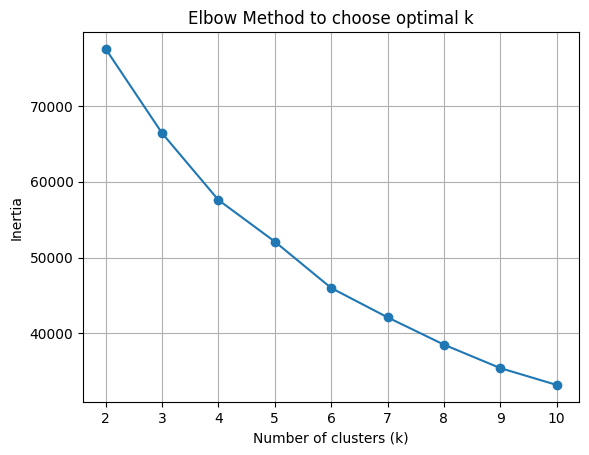

In [58]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method to choose optimal k")
plt.grid(True)
plt.show()


## (Optional) Silhouette Score để xác nhận

In [59]:
from sklearn.metrics import silhouette_score

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette score for k={k}: {score:.3f}")


Silhouette score for k=2: 0.427
Silhouette score for k=3: 0.321
Silhouette score for k=4: 0.318
Silhouette score for k=5: 0.338
Silhouette score for k=6: 0.230


## Huấn luyện mô hình KMeans cuối cùng

In [81]:
optimal_k = 4  # ví dụ sau khi xem elbow
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
X["segment_cluster"] = kmeans_final.fit_predict(X_scaled)
df["segment_cluster"] = X["segment_cluster"]


##  Phân tích profile từng cụm

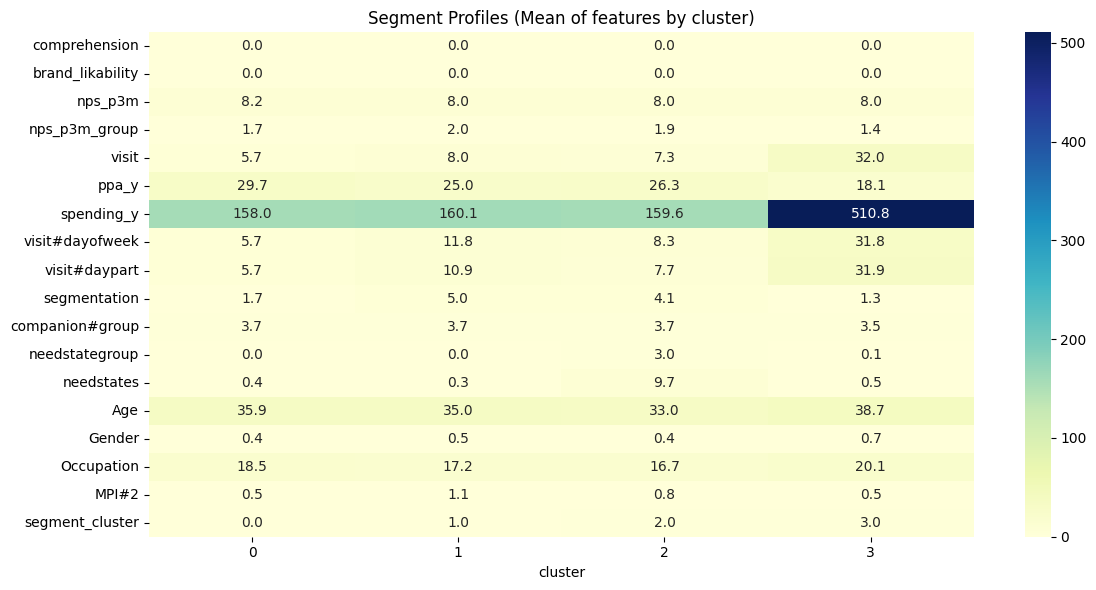

In [82]:
cluster_profile = X.assign(cluster=X["segment_cluster"]).groupby("cluster").mean()
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile.T, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Segment Profiles (Mean of features by cluster)")
plt.tight_layout()
plt.show()


# STEP 3: CHURN PREDICTION MODELING

## Tạo churn flag

In [62]:
df["p3m"] = df["p3m"].fillna(0)
df["p1m"] = df["p1m"].fillna(0)

df["churn_flag"] = df.apply(
    lambda x: 1 if (x["p3m"] == 1 and x["p1m"] == 0) else 0,
    axis=1
)

df["churn_flag"].value_counts()


churn_flag
0    11758
1        3
Name: count, dtype: int64

##  Chọn tập đặc trưng (features) 

In [69]:
features = [
    "comprehension", "brand_likability", "nps_p3m", "nps_p3m_group",
    "visit", "ppa_y", "spending_y", "visit#dayofweek", "visit#daypart",
    "segmentation", "companion#group", "needstategroup", "needstates",
    "Age", "Gender", "Occupation", "MPI#2",
    "segment_cluster"  # Gắn từ bước phân cụm
]


X = df[features].copy()
y = df["churn_flag"]

## Tạo X, y và xử lý missing / encode
 

In [70]:
X = df[features].copy()
y = df["churn_flag"]

# Fill NaN
X = X.fillna(X.median(numeric_only=True))

# Encode cột object (nếu có)
from sklearn.preprocessing import LabelEncoder
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))


## Xử lý mất cân bằng (upsample churn = 1)

In [ ]:
df_balanced = X.copy()
df_balanced["churn_flag"] = y

churn = df_balanced[df_balanced["churn_flag"] == 1]
non_churn = df_balanced[df_balanced["churn_flag"] == 0]

churn_upsampled = resample(churn, replace=True, n_samples=500, random_state=42)

df_final = pd.concat([non_churn, churn_upsampled]).sample(frac=1, random_state=42)

X_final = df_final.drop(columns=["churn_flag"])
y_final = df_final["churn_flag"]


## Chia tập train/test

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)


## Huấn luyện mô hình Random Forest (baseline)


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[2352    0]
 [   0  100]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2352
           1       1.00      1.00      1.00       100

    accuracy                           1.00      2452
   macro avg       1.00      1.00      1.00      2452
weighted avg       1.00      1.00      1.00      2452



## Tuning với GridSearchCV 

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring="f1",
    cv=3,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("✅ Best Params:", grid.best_params_)


✅ Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


## Phân tích churn driver (feature importance)


C:\Users\Dell\AppData\Local\Temp\ipykernel_24876\789820241.py:15: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dell\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


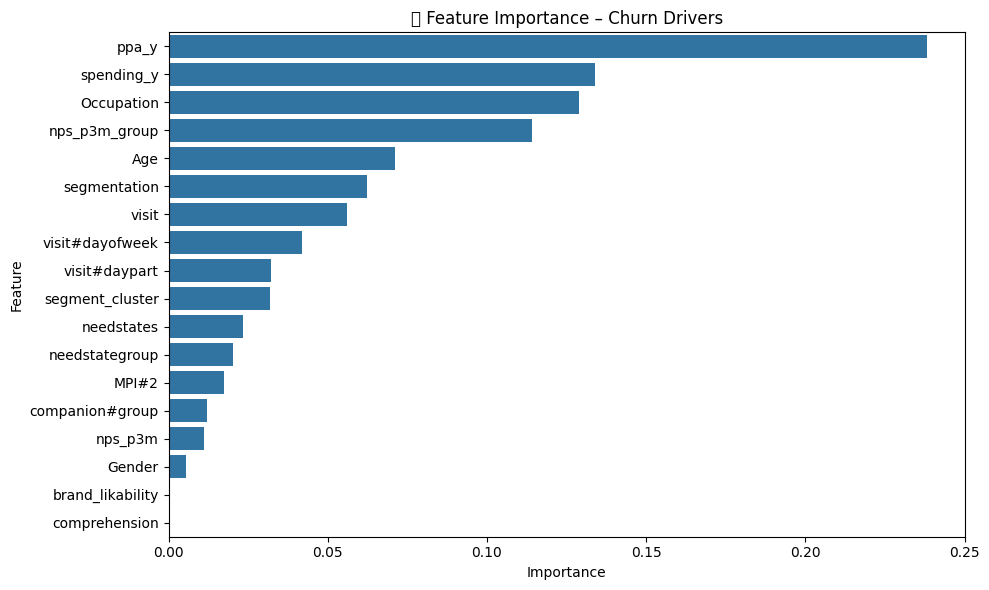

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lấy importance
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("🔥 Feature Importance – Churn Drivers")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
